In [19]:
import os
import glob
from collections import defaultdict
import random


import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import cv2 as cv
import imagesize
import torchvision.transforms as T
from PIL import Image
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from dataset import TrashDataset

#### Create Dataset

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 520 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 1220 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 2120 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 3020 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done 4120 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done 5220 tasks      | elapsed:   15.6s
[Parallel(n_jobs=10)]: Done 6520 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done 7820 tasks      | elapsed:   22.3s
[Parallel(n_jobs=10)]: Done 9320 tasks      | elapsed:   24.6s
[Parallel(n_jobs=10)]: Done 10820 tasks      | elapsed:   28.1s
[Parallel(n_jobs=10)]: Done 12520 tasks      | elapsed:   30.1s
[Parallel(n_jobs=10)]: Done 14220 tasks      | elapsed:   32.5s
[Parallel(n_jobs=10)]: Done 16120 tasks  

39900


[Parallel(n_jobs=10)]: Done 39900 out of 39900 | elapsed:  1.4min finished


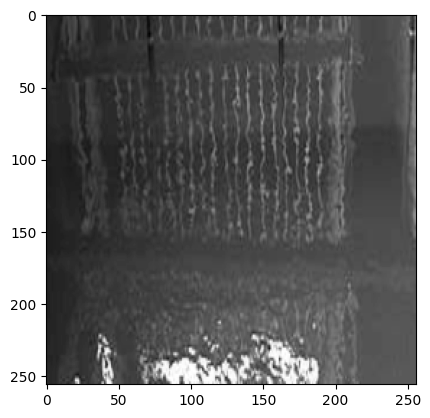

In [9]:
dataset = TrashDataset("../student_db", train=True)
print(len(dataset))
# dataset[-1][0].size()
plt.imshow(dataset[-1][0].permute(1, 2, 0),cmap="gray")

### Simple VAE model

##### General settings

In [3]:
dataset_path = '../student_db'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 3990#2100

x_dim  = 65536
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 200

#### Encoder

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

#### Decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

#### Whole Model

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder,):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [8]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [9]:
train_dataset = TrashDataset(dataset_path, train=True)
test_dataset  = TrashDataset(dataset_path, train=False)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done 520 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 1220 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 2120 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 3020 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done 4120 tasks      | elapsed:   12.0s
[Parallel(n_jobs=10)]: Done 5220 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done 6520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done 7820 tasks      | elapsed:   19.0s
[Parallel(n_jobs=10)]: Done 9320 tasks      | elapsed:   21.3s
[Parallel(n_jobs=10)]: Done 10820 tasks      | elapsed:   24.6s
[Parallel(n_jobs=10)]: Done 12520 tasks      | elapsed:   26.5s
[Parallel(n_jobs=10)]: Done 14220 tasks      | elapsed:   28.7s
[Parallel(n_jobs=10)]: Done 16120 tasks  

In [11]:
kwargs = {'num_workers': 10, 'pin_memory': True} 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [11]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'outputs/model_{epochs}.pth')

In [12]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        print(loss.item())
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        save_model(epochs=epoch, model=model,optimizer=optimizer,criterion=loss)
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
181629232.0
66546569216.0
6576381952.0
108497526784.0
16910159872.0
21785286656.0
3417102592.0
3192528640.0
416448480.0
199839248.0
Saving final model...
	Epoch 1 complete! 	Average Loss:  6341505.783124478
195701120.0
206210576.0
194856816.0
212631312.0
194341984.0
214327008.0
197341744.0
194850144.0
194588992.0
193233392.0
	Epoch 2 complete! 	Average Loss:  55641.41152882206
194786080.0
194794128.0
193961440.0
195267328.0
194950768.0
195060096.0
195597968.0
193876256.0
195730224.0
196954480.0
	Epoch 3 complete! 	Average Loss:  54329.67886382623
195447952.0
199692848.0
196750256.0
197547472.0
195997184.0
196610848.0
196200736.0
196232832.0
195452432.0
195633056.0
	Epoch 4 complete! 	Average Loss:  54735.884600389865
195367872.0
195029552.0
194932528.0
194465376.0
194623280.0
193931264.0
194071488.0
193830464.0
193272704.0
193331104.0
	Epoch 5 complete! 	Average Loss:  54103.47067669173
193561776.0
193070144.0
192823600.0
192188288.0
192234960.0
192308864.0
192226

../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [96,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [97,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [98,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [99,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [100,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [101,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [28,0,0], thread: [102,0,0] Assertion `input_val >= zero && input_va

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### Generate images from test dataset

In [13]:

weights = torch.load("outputs/model_70.pth")
model = Model(Encoder=encoder, Decoder=decoder)
model.load_state_dict(weights["model_state_dict"])
model.to(DEVICE)
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/2 [00:03<?, ?it/s]

In [16]:
def show_image(x, idx):
    x = x.view(batch_size, 256, 256)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

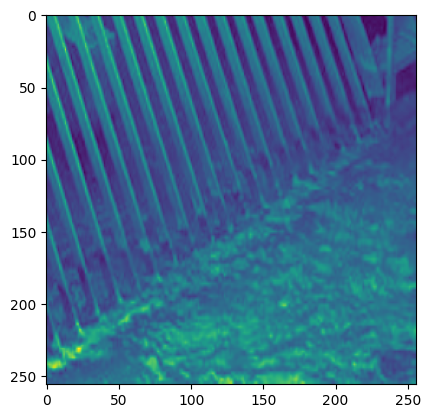

In [17]:
show_image(x, idx=0)

#### Reconstructed image, not good at all

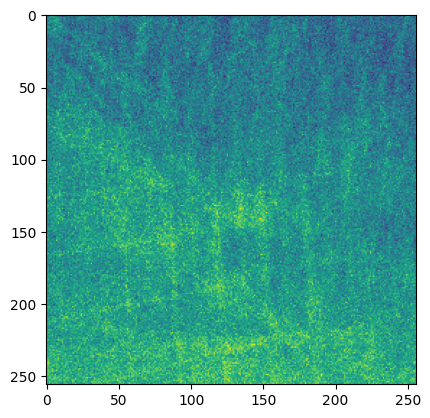

In [18]:
show_image(x_hat, idx=0)